## Second level GLM analysis

This script performs group level modeling of BOLD response. Script features: 
- ...

---
**Last update**: 14.02.2020 

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

import nibabel as nib
from nilearn import plotting, datasets
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nistats.reporting import plot_design_matrix, get_clusters_table
from scipy.stats import norm

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data         

### Load statistical maps 

In this section statistical maps (output .nii files from first-level GLM analysis) are loaded. Additional metadata for subject labels stored in `meta` dictionary is also loaded. Next, individual t-maps for left minus right button press contrast are plotted on glass brain models (fixed statistical threshold). Note subject m19 responding with reversed grips (technical error).

In [3]:
# Directory to save second level output
path_out = os.path.join(path_root, 
                        'data/main_fmri_study/derivatives/nistats/second_level_output')
os.makedirs(path_out, exist_ok=True)

# Load behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh)
n_subjects, n_conditions, n_trials, _ = beh.shape

Shape of beh array: (32, 2, 110, 23)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'block_bci'), (2, 'side'), (3, 'side_bci'), (4, 'magn_left'), (5, 'magn_right'), (6, 'response'), (7, 'rt'), (8, 'won_bool'), (9, 'won_magn'), (10, 'acc_after_trial'), (11, 'onset_iti'), (12, 'onset_iti_plan'), (13, 'onset_iti_glob'), (14, 'onset_dec'), (15, 'onset_dec_plan'), (16, 'onset_dec_glob'), (17, 'onset_isi'), (18, 'onset_isi_plan'), (19, 'onset_isi_glob'), (20, 'onset_out'), (21, 'onset_out_plan'), (22, 'onset_out_glob')]


In [5]:
os.listdir(path_first_level_output)

['out_perr', 'res_lbp_minus_rbp', 'out_ons']

In [38]:
# Load stat-map images (first level output)
path_first_level_output = os.path.join(path_root, 
                                       'data/main_fmri_study/derivatives/nistats/first_level_output')

contrast = 'res_lbp_minus_rbp'

path_contrast = os.path.join(path_first_level_output, contrast)
tmap_files = [sorted([os.path.join(path_contrast, file) 
                      for file in os.listdir(path_contrast) if task in file]) 
              for task in ['prlrew', 'prlpun']]

tmap_img = []
for con_idx in range(n_conditions):
    tmap_img_con = []
    for sub_idx in range(n_subjects):
        tmap_img_con.append(nib.load(tmap_files[con_idx][sub_idx]))
    tmap_img.append(tmap_img_con)

In [ ]:
# fig, ax = plt.subplots(
#     nrows=8, ncols=4, 
#     facecolor='w', figsize=(15, 30))

# for cidx, tmap in enumerate(tmap_img[0]):
#     plotting.plot_glass_brain(
#         tmap, 
#         colorbar=False, 
#         threshold=2.5,
#         title=meta['dim1'][cidx],
#         axes=ax[int(cidx / 4)][int(cidx % 4)],
#         plot_abs=False,
#         display_mode='z')

## Group analysis

Here, group analysis is performed for various model-based regressors. All subject data from both task conditions is considered. Group level statistical map for main effect is then calculated. Then the result is displayed on the MNI152 non-linear asymmetric template (version 2009c; default template for fmriprep).

### Main effect of [regessor] across conditions

In [39]:
second_level_input = [tmap for tmaps in tmap_img for tmap in tmaps]
second_level_model = SecondLevelModel(smoothing_fwhm=0)

design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

second_level_model = second_level_model.fit(
    second_level_input, 
    design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(output_type='z_score')

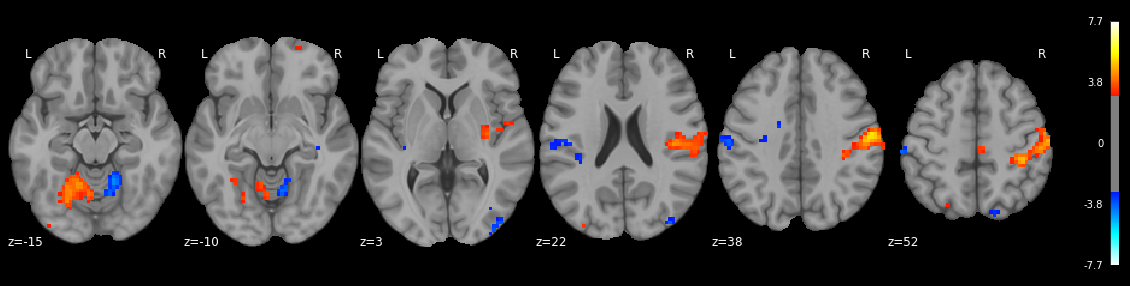

In [41]:
# Setup
p_val = 0.05
height_control = 'fdr'
cut_coords = (-15, -10, 3, 22, 38, 52)
display_mode = 'z'

# Plotting
mni152nlin2009c = "mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/"\
                  "temp.nii.gz"
bg_img = datasets.load_mni152_template()
bg_img = nib.load(mni152nlin2009c)

z_map_thresholded, threshold = map_threshold(
    z_map,
    alpha=p_val,
    height_control=height_control,
    cluster_threshold=15)

fig, ax = plt.subplots(ncols=1, nrows=1, facecolor='k', figsize=(20, 5))
plotting.plot_stat_map(
    z_map,
    bg_img=bg_img,
    axes=ax,
    threshold=threshold,
    colorbar=True,
    display_mode=display_mode,
    cut_coords=cut_coords)


### Difference in [regressos] scaling between conditions

In [ ]:
second_level_input = [tmap for tmaps in tmap_img for tmap in tmaps]
second_level_model = SecondLevelModel(smoothing_fwhm=6)

# Paired two-group difference for reward – punishment contrast
columns = ['con_diff'] + \
          [f'sub-m{sub:02}' for sub in range(2, n_subjects+2)]
design_matrix = pd.DataFrame(np.hstack((
    np.vstack((np.ones((n_subjects, 1)), (-1)*np.ones((n_subjects, 1)))),   
    np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
    )), columns=columns)

contrast = np.zeros(design_matrix.shape[1])
contrast[list(design_matrix.columns).index('con_diff')] = 1

fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w')
plot_design_matrix(design_matrix, ax=ax)

second_level_model = second_level_model.fit(
    second_level_input, 
    design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(
    contrast,
    output_type='z_score')

In [ ]:
p_val = 0.05
height_control = 'fdr'
title = 'Epw difference between conditions'

################################################################################
mni152nlin2009c = "mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/"\
                  "temp.nii.gz"
bg_img = datasets.load_mni152_template()
bg_img = nib.load(mni152nlin2009c)

z_map_thresholded, threshold = map_threshold(
    z_map,
    level=0.9,
    height_control="bonferroni")
#     cluster_threshold=15)

for display_mode in ['x', 'y', 'z']:

    fig, ax = plt.subplots(ncols=1, nrows=1, facecolor='k', figsize=(20, 5))
    display = plotting.plot_stat_map(
        z_map,
        bg_img=bg_img,
        axes=ax,
        threshold=threshold,
        colorbar=True,
        display_mode=display_mode,
        cut_coords=(0, 10, 21),
        title=f'{title} ({height_control} p<{p_val})')

### Condition-specific [surprise] activations

In [ ]:
z_maps = []

for condition in [0, 1]:
    
    second_level_input = [tmap for tmap in tmap_img[condition]]
    second_level_model = SecondLevelModel(smoothing_fwhm=8)

    # Main effect of PE for condition
    design_matrix = pd.DataFrame([1] * len(second_level_input),
                                 columns=['intercept'])

    second_level_model = second_level_model.fit(
        second_level_input, 
        design_matrix=design_matrix)

    z_maps.append(second_level_model.compute_contrast(output_type='z_score'))

In [ ]:
p_val = 0.01
height_control = 'fdr'
cut_coords = (-15, -10, 3, 22, 38, 52)
display_mode = 'z'

################################################################################
mni152nlin2009c = "mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/"\
                  "temp.nii.gz"
bg_img = datasets.load_mni152_template()
bg_img = nib.load(mni152nlin2009c)

for con, z_map in enumerate(z_maps): 
    
    if con == 0:
        title = 'Surprise in reward condition'
    else:
        title = 'Surprise in punishment condition'
    
    z_map_thresholded, threshold = map_threshold(
        z_map,
        level=p_val,
        height_control='fdr',
        cluster_threshold=15)

    fig, ax = plt.subplots(ncols=1, nrows=1, facecolor='k', figsize=(20, 5))
    display = plotting.plot_stat_map(
        z_map,
        bg_img=bg_img,
        axes=ax,
        threshold=threshold,
        colorbar=True,
        display_mode=display_mode,
        cut_coords=cut_coords,
        title=f'{title} ({height_control} p<{p_val})')

In [ ]:
tb = get_clusters_table(z_map_thresholded, threshold, cluster_threshold=15, min_distance=8.0)
tb = tb.loc[tb['Cluster Size (mm3)'] != '']